In [1]:
%matplotlib notebook
%matplotlib inline

import pandas as pd
import numpy as np
import os
import random
import copy
import pprint
#import glob
#import sys


import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('figure', figsize = (20, 8))
plt.rc('font', size = 14)
plt.rc('axes.spines', top = False, right = False)
plt.rc('axes', grid = False)
plt.rc('axes', facecolor = 'white')

from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow import feature_column
import tensorflow_hub as hub

In [2]:
params = {'sample_perc':1,
          'bs': 16,
          'epochs': 11, 
          'n_folds': 5,
          'optimizer': 'adam',
          'lr': 5e-03,
          #'momentum': 0.9,
          'wd': 0.01,
          'seed': 123,
          'hidden_layers': [16],
         }

In [3]:
data_dir = 'heart_disease_data/'

In [4]:
def random_seed(seed_value):
    np.random.seed(seed_value) # cpu vars
    random.seed(seed_value) # Python
    tf.random.set_seed(seed_value) #TF

In [5]:
random_seed(params['seed'])

In [6]:
def load_dataset(seed=123):
    '''Load data and split into train and test set'''
    
    df = pd.read_csv(data_dir + 'heart.csv')    
    random_seed(seed)
    stratified_split = StratifiedKFold(5, shuffle=True, random_state=seed)
    train_indexes, test_indexes = next(stratified_split.split(df.loc[:,df.columns!=dep_name[0]], df[dep_name[0]]))
    train = df.loc[train_indexes]
    test = df.loc[test_indexes]
    print(df.shape, train.shape, test.shape)    
    return (df, train, test)

In [7]:
tf.__version__ #tf 2.1.0 is used

'2.0.0'

In [8]:
#allocate variables to data types
cat_vars = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

cont_vars = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

dep_name = ['target']

In [9]:
#load data
df, train, test = load_dataset(params['seed'])

(303, 14) (242, 14) (61, 14)


In [10]:
# 1 indicates no heart disease and 0 indicates heart disease
df['target'].value_counts()

1    165
0    138
Name: target, dtype: int64

In [11]:
# Scaling the numerical features
scaler = preprocessing.MinMaxScaler().fit(train[cont_vars])
train[cont_vars] = scaler.transform(train[cont_vars])
test[cont_vars] = scaler.transform(test[cont_vars])

# Categorify categorical features
for col in cat_vars:
    train[col] = train[col].astype(str)
    test[col] = test[col].astype(str)
    df[col] = df[col].astype(str)

In [12]:
def df_to_dataset(dataframe, shuffle:bool=True, batch_size=32):
    '''Create tf.data dataset from pandas DataFrame
    
    Parameters:
    dataframes: pandas DataFrame
    shuffle: Boolean indicating whether to shuffle the data
    batch_size: batch size
    
    Returns a tf.data dataset
    '''
    
    dataframe = dataframe.copy()
    labels = dataframe.pop(dep_name[0])
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        random_seed(params['seed'])
        ds = ds.shuffle(buffer_size=len(dataframe))
    if batch_size == None:
        # complete data in 1 batch
        ds = ds.batch(len(labels))
    else:
        ds = ds.batch(batch_size)
    return ds

In [13]:
#Define embedding dimensions either through setting all variable's dimensions to one value
#or through calculating the dimensions based on the fastai rule
print('Entity Embedding Dimensions:')
emb_szs = {}
for column in df[cat_vars]:
    n_cat = df[column].nunique()
    emb_szs[column] = min(600, round(1.6 * n_cat**0.56)) #fastai rule
    #emb_szs[column] = 5
    print(f'{column}: {n_cat} classes -> {emb_szs[column]} dimensions')
params['emb_szs'] = emb_szs

Entity Embedding Dimensions:
sex: 2 classes -> 2 dimensions
cp: 4 classes -> 3 dimensions
fbs: 2 classes -> 2 dimensions
restecg: 3 classes -> 3 dimensions
exang: 2 classes -> 2 dimensions
slope: 3 classes -> 3 dimensions
ca: 5 classes -> 4 dimensions
thal: 4 classes -> 3 dimensions


In [14]:
#Create feature columns and the final input for the neural network

# Numeric Columns
numeric_columns = {
    col : feature_column.numeric_column(col) \
          for col in cont_vars
}

# Categorical Columns
categorical_columns = {
    col: feature_column.categorical_column_with_vocabulary_list(col, df[col].unique().tolist()) \
        for col in cat_vars
}

#Embeddings
params['encoding'] = 'Entity Embeddings'
for col in categorical_columns:
    categorical_columns[col] = feature_column.embedding_column(categorical_columns[col], dimension=emb_szs[col])
    
'''
#One Hot encoding
params['encoding'] = 'One-Hot Encoding'
for col in categorical_columns:
    categorical_columns[col] = feature_column.indicator_column(categorical_columns[col])
'''

# Prepare the final inputs: uncomment the section of the inputs that should be used for the NN

# Combined inputs (categorical and numeric)
#uncomment this section (and comment sections below) to use categorical and numeric inputs
'''
input_tab = {
    colname : tf.keras.layers.Input(name=colname, shape=(), dtype='float32') \
          for colname in numeric_columns.keys()
}
input_tab.update({
    colname : tf.keras.layers.Input(name=colname, shape=(),  dtype='string') \
          for colname in categorical_columns.keys()
})

#capture all feature columns in 1 vector
feat_cols = list(numeric_columns.values()) + list(categorical_columns.values())
'''


# Separated inputs (either numeric or categorical)
#only numeric inputs
#uncomment this section (and comment sections above and below) to only use numeric inputs
'''
feat_cols = list(numeric_columns.values())
input_tab = {
    colname : tf.keras.layers.Input(name=colname, shape=(), dtype='float32') \
          for colname in numeric_columns.keys()
}
'''

#only categorical inputs
#uncomment this section (and comment sections above) to only use categorical inputs
feat_cols = list(categorical_columns.values())
input_tab = {
    colname : tf.keras.layers.Input(name=colname, shape=(),  dtype='string') \
          for colname in categorical_columns.keys()
}

In [15]:
#Prepare evaluation metrics
METRICS = [keras.metrics.TruePositives(name='tp'),
           keras.metrics.FalsePositives(name='fp'),
           keras.metrics.TrueNegatives(name='tn'),
           keras.metrics.FalseNegatives(name='fn'), 
           keras.metrics.BinaryAccuracy(name='binary_accuracy'),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           keras.metrics.AUC(name='auc')
    ]

def get_optimizer():
    '''Function that returns an optimzer based on the parameters for the model'''
    
    if params['optimizer'] == 'sgd':
        optimizer = keras.optimizers.SGD(lr=params['lr'], momentum=params['momentum'], decay=params['wd'])
    elif params['optimizer'] == 'adam':
        optimizer = keras.optimizers.Adam(lr=params['lr'])
    elif params['optimizer'] == 'rmsprop':
        optimizer = keras.optimizers.RMSprop(lr=params['lr'], momentum=params['momentum'])
    else:
        raise Exception('Wrong input for optimizer parameter given.')
    return optimizer

#early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        verbose=1,
        patience=3,
        mode='min',
        restore_best_weights=True)

In [16]:
def create_tab_model():
    '''Function that creates and compiles the neural network'''
    #create a feature layer
    feature_layer_tab = keras.layers.DenseFeatures(feat_cols)(input_tab)
    
    #create hidden layers
    tab_layer = keras.layers.Dense(params['hidden_layers'][0], activation='relu', use_bias = True, kernel_regularizer=tf.keras.regularizers.l2(params['wd']))(feature_layer_tab)
    tab_layer = keras.layers.Dropout(0.5)(tab_layer)
    if len(params['hidden_layers'])>1:
        tab_layer = keras.layers.Dense(params['hidden_layers'][1], activation='relu', use_bias = True, kernel_regularizer=tf.keras.regularizers.l2(params['wd']))(tab_layer)
        tab_layer = keras.layers.Dropout(0.5)(tab_layer)
    if len(params['hidden_layers'])>2:
        tab_layer = keras.layers.Dense(params['hidden_layers'][2], activation='relu', use_bias = True, kernel_regularizer=tf.keras.regularizers.l2(params['wd']))(tab_layer)
        tab_layer = keras.layers.Dropout(0.5)(tab_layer)
        
    #create output layer
    z = keras.layers.Dense(1, activation="sigmoid")(tab_layer)

    random_seed(params['seed'])
    model = keras.Model(inputs=[input_tab], outputs=z)

    optimizer = get_optimizer()
    
    #compile neural network
    random_seed(params['seed'])
    model.compile(optimizer= optimizer,
                  loss='binary_crossentropy',
                  metrics=METRICS)
    return model

In [17]:
model = create_tab_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ca (InputLayer)                 [(None,)]            0                                            
__________________________________________________________________________________________________
cp (InputLayer)                 [(None,)]            0                                            
__________________________________________________________________________________________________
exang (InputLayer)              [(None,)]            0                                            
__________________________________________________________________________________________________
fbs (InputLayer)                [(None,)]            0                                            
______________________________________________________________________________________________

**Helper Functions**

In [18]:
def order_history(history):
    train_dict=dict()
    val_dict=dict()
    for (key, value) in history.items():
       # Check if key is even then add pair to new dictionary
        if key.split('_')[0] == 'val':
            val_dict[key] = value
        else:
            train_dict[key] = value
    ordered_history = train_dict.copy()
    ordered_history.update(val_dict)
    return ordered_history

def add_fold_to_dict(history, dt):
    history = history.copy()
    if dt == {}:
        dt = dict(history)
    else:
        for key in dt.keys():
            dt[key].extend(history[key])
    return dt

def get_avg_column_val(df):
    averages = list()
    for i in range(len(df.columns)):
        averages.append(df[i].mean())
    return averages

def kfold_results(dt, n_folds, epochs):
    averages = dict()
    for key in dt.keys():
        df = pd.DataFrame(pd.Series(dt[key]).values.reshape(n_folds,epochs))
        averages[key] = get_avg_column_val(df)
    epochs = np.arange(epochs)
    results_lists = {'epochs': epochs}
    results_lists.update(averages)
    results = pd.DataFrame(results_lists)
    return results

def plot_kfold_results(results):
    nb_epochs=results.shape[0]
    fig,ax = plt.subplots(2,1,figsize=(8,12))
    fig.suptitle('Results - averaged over folds')
    ax[0].plot(list(range(nb_epochs)), results['loss'], label='Training loss')
    ax[0].plot(list(range(nb_epochs)), results['val_loss'], label='Validation loss')
    ax[0].set_xlabel('Epoch')
    ax[0].xaxis.set_ticks(np.arange(0,nb_epochs,1))
    ax[0].set_ylabel('Loss')
    ax[0].legend(loc='best')
    ax[1].plot(list(range(nb_epochs)),results['binary_accuracy'], label='Training Accuracy')
    ax[1].plot(list(range(nb_epochs)),results['val_binary_accuracy'], label='Validation Accuracy')
    ax[1].xaxis.set_ticks(np.arange(0,nb_epochs,1))
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy / %')
    ax[1].legend(loc='best')

def print_results(cv_results, test_results=None):
    print('\n')
    print('-'*15)
    print('Test Set Results:')
    print('\n')
    pprint.pprint(test_results)
    
    print('\n')
    print('-'*15)
    print('Cross-Validation Results (averaged over folds):')
    print('\n')
    print(cv_results)
    plot_kfold_results(cv_results)

In [19]:
def fit_model_test(train, test, model_fn, epochs, bs): 
    '''
    Function to fit model on complete training data and evaluate on test data
    
    Parameters:
    train: training data as pandas DataFrame
    test: testing data as pandas DataFrame
    model_fn: function name that creates the neural network
    epochs: number of epochs to train
    bs: batch size
    
    Returns evaluation results and training history
    '''
    
    train = train.copy()
    test = test.copy()
    
    #get TF datasets from pandas DataFrame
    random_seed(params['seed'])
    train_ds = df_to_dataset(train, shuffle=False, batch_size=bs)
    test_ds = df_to_dataset(test, shuffle=False, batch_size=None)
    
    #create and fit model on complete training data
    random_seed(params['seed'])
    model = model_fn()
    random_seed(params['seed'])
    history = model.fit(train_ds, validation_data=test_ds, epochs=epochs, callbacks=[early_stopping])
    
    #evaluate the network with the test set
    test_results = dict()
    evaluation = model.evaluate(test_ds, callbacks=[])
    for idx, metric in enumerate(model.metrics_names):
        test_results['test_' + metric] = evaluation[idx]
    print(test_results)
    
    return (test_results, history)

In [20]:
def fit_model_cv(train, model_fn, epochs, n_folds, bs, test=None):
    '''
    Function to fit model on training data with cross-validation
    
    Parameters:
    train: training data as pandas DataFrame
    model_fn: function name that creates the neural network
    epochs: number of epochs to train
    n_folds: number of folds into which the training data should be splitted
    bs: batch size
    test: optional - if given, additionally, a neural network is trained on the complete training data and evaluated on the test data

    
    Returns cross-validation results
    '''
    
    train = train.copy()
    if test is not None:
        test = test.copy()
        
    #tracking variable
    folds = dict()
    
    #prepare cross validation
    random_seed(params['seed'])
    stratified_k_fold = StratifiedKFold(n_folds, shuffle=True, random_state=1)
    
    #iterate over folds
    for iteration_idx, (train_idxs, valid_idxs) in enumerate(stratified_k_fold.split(train.loc[:,train.columns!=dep_name[0]], train[dep_name])):
        fold_idx = iteration_idx+1
        print('-'*20, '\n', f'> Fold: {fold_idx}'); print('-'*20)
        
        #get training and validation sets
        train_df = train.iloc[train_idxs]
        val_df = train.iloc[valid_idxs]
        #transform DataFrames into TF datasets
        train_ds = df_to_dataset(train_df, shuffle=False, batch_size=bs)
        val_ds = df_to_dataset(val_df, shuffle=False, batch_size=None)
        
        #get model
        random_seed(params['seed'])
        model = model_fn()
        
        #fit model
        random_seed(params['seed'])
        history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[], verbose=0)
        history.history = order_history(history.history)
        
        #add fold to dict
        folds = add_fold_to_dict(history.history, folds)
        
        #clear session
        keras.backend.clear_session()
    
    #get results    
    results = kfold_results(folds, n_folds, epochs)
    experiment_results = [results]
    
    if test is not None:
        #train a network on complete training set and evaluate on test set
        print('-'*15)
        print('Test Set: \n')
        
        #create, fit and evaluate network
        test_results, history_test = fit_model_test(train, test, params['model_fn'], epochs=epochs, bs=params['bs'])
        
        #get trained epochs in case network stopped early through callback
        final_epochs = epochs if early_stopping.stopped_epoch==0 else (early_stopping.stopped_epoch-early_stopping.patience+1)
        
        experiment_results.append(test_results)
     
    #show results
    if test is not None:
        print_results(experiment_results[0], experiment_results[1])
    else:
        print_results(experiment_results[0])
    return experiment_results

-------------------- 
 > Fold: 1
--------------------
-------------------- 
 > Fold: 2
--------------------
-------------------- 
 > Fold: 3
--------------------
-------------------- 
 > Fold: 4
--------------------
-------------------- 
 > Fold: 5
--------------------
---------------
Test Set: 

Epoch 1/11
16/16 [==============================] - 6s 373ms/step - loss: 1.2310 - tp: 132.0000 - fp: 109.0000 - tn: 1.0000 - fn: 0.0000e+00 - binary_accuracy: 0.5496 - precision: 0.5477 - recall: 1.0000 - auc: 0.3487 - val_loss: 0.0000e+00 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 2/11
16/16 [==============================] - 0s 8ms/step - loss: 0.7683 - tp: 130.0000 - fp: 92.0000 - tn: 18.0000 - fn: 2.0000 - binary_accuracy: 0.6116 - precision: 0.5856 - recall: 0.9848 - auc: 0.7625 - val_loss: 0.6823 - val_tp: 33.0000 - val_fp: 20.0000 -

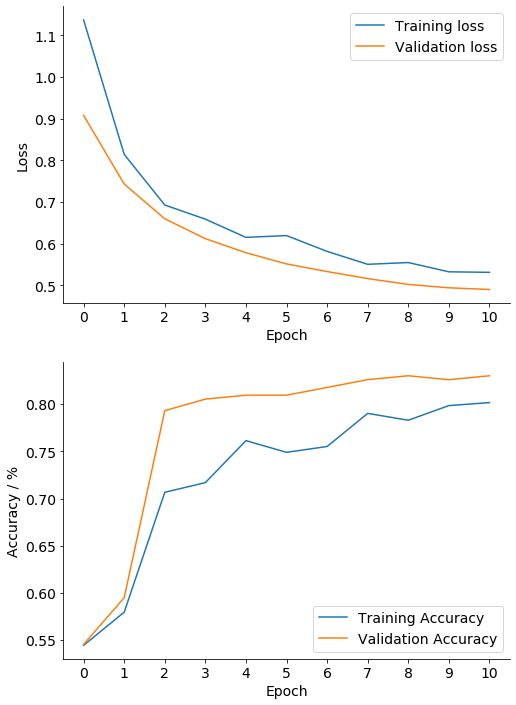

In [21]:
params['model_fn'] = create_tab_model
_ = fit_model_cv(train, test=test, model_fn=params['model_fn'], epochs=params['epochs'], n_folds=params['n_folds'], bs=params['bs'])